<a href="https://colab.research.google.com/github/OlegBEZb/Personalize-Expedia-Hotel-Searches/blob/main/AutoSklearnClf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

!pip install scipy -U
!pip install auto-sklearn
!pip install kaggle
!pip install pandas-profiling -U
!pip install category_encoders

In [2]:
import os
import sklearn
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = '/content/drive/MyDrive/Personalize-Expedia-Hotel-Searches'  # data if local

In [5]:
USE_FULL = False

filename = os.path.join(data_path, 'training_set_VU_DM.csv')

if USE_FULL:
    df = pd.read_csv(filename)
else:
    import random
    p = 0.1
    df = pd.read_csv(filename,
                     header=0,
                     skiprows=lambda i: i > 0 and random.random() > p)

df['date_time'] = pd.to_datetime(df['date_time'])
df.shape

(495236, 54)

# Simple preproc + split



In [6]:
def get_target(row):
    """
    0=not clicked at all, 1=clicked but not booked, 5=booked
    """
    if row.booking_bool>0:
        return 5
    if row.click_bool>0 :
        return 1
    return 0

from sklearn.model_selection import train_test_split


def train_test_group_split(*arrays,
                           group_array=None,
                           train_size=None):
    """


    Example
    X_train2, X_test2, y_train2, y_test2, groups_train2, groups_test2 = train_test_group_split(X, y, groups, group_array=groups, train_size=0.9)
    """

    grp_changes = group_array.shift() != group_array
    grp_changes_train_approx = grp_changes.iloc[:int(len(grp_changes) * train_size)]
    split_index = grp_changes_train_approx[grp_changes_train_approx].last_valid_index()
    return train_test_split(*arrays, train_size=split_index, shuffle=False)

In [7]:
CAT_FEATURES = ['site_id',
            'visitor_location_country_id',
            'prop_country_id',
            'prop_id',
            'srch_destination_id']

bool_cols = ['prop_brand_bool',
             'promotion_flag',
             'srch_saturday_night_bool',
             'random_bool']

group_col = 'srch_id'


clf_target = 'target'
df[clf_target] = df.apply(get_target, axis=1)

In [8]:
def get_time_features(pdf: pd.DataFrame, time_col):
    pdf['day'] = pdf[time_col].dt.day.astype(np.int8)
    pdf['month'] = pdf[time_col].dt.month.astype(np.int8)
    pdf['year'] = pdf[time_col].dt.year.astype(np.int16)
    pdf['quarter'] = pdf[time_col].dt.quarter.astype(np.int8)
    pdf['week'] = pdf[time_col].dt.isocalendar().week.astype(np.int8)
    pdf['dow'] = (pdf[time_col].dt.dayofweek + 1).astype(np.int8)
    pdf['doy'] = pdf[time_col].dt.dayofyear.astype(np.int16)
    pdf['days_in_month'] = pdf[time_col].dt.days_in_month.astype(np.int8)

    pdf["is_weekend"] = pdf["dow"].apply(lambda x: 1 if x in [6, 7] else 0).astype(np.int8)
    pdf['is_month_start'] = pdf[time_col].dt.is_month_start.astype(np.int8)
    pdf['is_month_end'] = pdf[time_col].dt.is_month_end.astype(np.int8)
    pdf['is_quarter_start'] = pdf[time_col].dt.is_quarter_start.astype(np.int8)
    pdf['is_quarter_end'] = pdf[time_col].dt.is_quarter_end.astype(np.int8)
    pdf['is_year_start'] = pdf[time_col].dt.is_year_start.astype(np.int8)
    pdf['is_year_end'] = pdf[time_col].dt.is_year_end.astype(np.int8)

    print('basics are calculated')

    def get_week_id(a_year, a_month, a_week):
        y = a_year
        if a_month == 12 and a_week == 1:
            y = a_year + 1
        elif a_month == 1 and a_week > 50:
            y = a_year - 1
        return y * 100 + a_week

    pdf['week_id'] = pdf.apply(lambda row: get_week_id(row.year, row.month, row.week), axis=1).astype(np.int32)
    # pdf['week_start'] = pdf.groupby(['week_id'])[time_col].transform('min')
    # pdf['week_end'] = pdf.groupby(['week_id'])[time_col].transform('max')
    pdf["season_num"] = (((pdf["month"]) // 3) % 4 + 1).astype(np.int8)
    pdf["week_summer_index"] = pdf["week"].apply(
        lambda w: w - 3 if w >= 3 and w <= 28 else 54 - w if w >= 29 else 0).astype(np.int8)

    print('week-related are calculated')

    return pdf

In [9]:
from copy import deepcopy
df = get_time_features(deepcopy(df), 'date_time')

import category_encoders as ce
enc = ce.OrdinalEncoder(cols=['date_time'])
df.sort_values(['date_time'], inplace=True)
df = enc.fit_transform(df)
# df.drop('date_time', axis=1, inplace=True)

basics are calculated
week-related are calculated


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,week_id,season_num,week_summer_index
121648,81578,1,5,219,NaN,NaN,219,5322,4,4.0,...,0,1,0,0,0,0,0,201244,4,10
121649,81578,1,5,219,NaN,NaN,219,59721,4,4.5,...,0,1,0,0,0,0,0,201244,4,10
121650,81578,1,5,219,NaN,NaN,219,69184,4,4.0,...,0,1,0,0,0,0,0,201244,4,10
121651,81578,1,5,219,NaN,NaN,219,79475,3,4.0,...,0,1,0,0,0,0,0,201244,4,10
265906,178890,2,16,31,NaN,NaN,215,2245,3,4.0,...,0,1,0,0,0,0,0,201244,4,10


In [24]:
df.sort_values([group_col, 'date_time'], inplace=True) 

y = df[clf_target]
X = df.drop(['position', 'click_bool', 'gross_bookings_usd', 'booking_bool', clf_target], axis=1)
# del df
groups = X[group_col]


X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test = train_test_group_split(X, y, groups,
                                                                                     group_array=groups,
                                                                                     train_size=0.9)
# del X, y

X_train, X_val, y_train, y_val, groups_train, groups_val = train_test_group_split(X_train_val, 
                                                                                  y_train_val,
                                                                                  groups_train_val,
                                                                                  group_array=groups_train_val,
                                                                                  train_size=0.9)

# from sklearn.model_selection import GroupShuffleSplit  # ignores time
# gss = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
# >>> gss.get_n_splits()
# 2
# >>> for train_idx, test_idx in gss.split(X, y, groups):
# ...     print("TRAIN:", train_idx, "TEST:", test_idx)

In [25]:
X_train.shape, X_val.shape, X_test.shape

((401137, 68), (44573, 68), (49526, 68))

# Modeling

In [26]:
minutes_limit = 20

## auto-sklearn

In [27]:
logging_config = {
    'version': 1,
    'disable_existing_loggers': True,
    'formatters': {
        'custom': {
            # More format options are available in the official
            # `documentation <https://docs.python.org/3/howto/logging-cookbook.html>`_
            'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        }
    },

    # Any INFO level msg will be printed to the console
    'handlers': {
        'console': {
            'level': 'INFO',
            'formatter': 'custom',
            'class': 'logging.StreamHandler',
            'stream': 'ext://sys.stdout',
        },
    },

    'loggers': {
        '': {  # root logger
            'level': 'DEBUG',
        },
        'Client-EnsembleBuilder': {
            'level': 'DEBUG',
            'handlers': ['console'],
        },
    },
}

In [28]:
import autosklearn.classification
import sklearn
from autosklearn.metrics import balanced_accuracy, precision, recall, f1_macro, accuracy

automl = autosklearn.classification.AutoSklearnClassifier(
    logging_config=logging_config,
    time_left_for_this_task=60*minutes_limit,
    # per_run_time_limit=30,
    ensemble_size=5,
    n_jobs=-1,
    memory_limit=5120,
    # tmp_folder='/tmp/autosklearn_resampling_example_tmp',
    disable_evaluator_output=False,
    # resampling_strategy=sklearn.model_selection.StratifiedKFold(),
    # resampling_strategy_arguments={'n_splits': 5},
    metric=f1_macro,
    scoring_functions=[balanced_accuracy, accuracy, precision, recall],
    # include={
    #     'classifier': [
    #         'decision_tree',# 'lda', 'sgd'
    #     ],
    #     'feature_preprocessor': [
    #         'no_preprocessing', #'polynomial', 'select_percentile_classification'
    #     ]
    # },
)
automl.fit(X_train, y_train, X_test=X_val, y_test=y_val)

2022-05-03 21:24:17,191 - Client-EnsembleBuilder - INFO - <Future: pending, key: fit_and_return_ensemble-ce0576def12e0c0b06f195e3c17f1f64>/<Client: 'inproc://172.28.0.2/2455/14' processes=2 threads=2> Started Ensemble builder job at 2022.05.03-21.24.17 for iteration 0.
2022-05-03 21:27:42,941 - Client-EnsembleBuilder - INFO - <Future: pending, key: fit_and_return_ensemble-75b15e7662b70490be0d7d91f4e28832>/<Client: 'inproc://172.28.0.2/2455/14' processes=2 threads=2> Started Ensemble builder job at 2022.05.03-21.27.42 for iteration 1.
2022-05-03 21:28:18,946 - Client-EnsembleBuilder - INFO - <Future: pending, key: fit_and_return_ensemble-70c4f7cf96e08c994880cca7edd9b375>/<Client: 'inproc://172.28.0.2/2455/14' processes=2 threads=2> Started Ensemble builder job at 2022.05.03-21.28.18 for iteration 2.
2022-05-03 21:28:24,816 - Client-EnsembleBuilder - INFO - <Future: pending, key: fit_and_return_ensemble-6b68fc83808308d1edc930eb7ac98bd8>/<Client: 'inproc://172.28.0.2/2455/14' processes=2 

AutoSklearnClassifier(ensemble_size=5,
                      logging_config={'disable_existing_loggers': True,
                                      'formatters': {'custom': {'format': '%(asctime)s '
                                                                          '- '
                                                                          '%(name)s '
                                                                          '- '
                                                                          '%(levelname)s '
                                                                          '- '
                                                                          '%(message)s'}},
                                      'handlers': {'console': {'class': 'logging.StreamHandler',
                                                               'formatter': 'custom',
                                                               'level': 'INFO',
                                

In [29]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: ca2a4306-cb26-11ec-8997-0242ac1c0002
  Metric: f1_macro
  Best validation score: 0.351885
  Number of target algorithm runs: 15
  Number of successful target algorithm runs: 3
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 9
  Number of target algorithms that exceeded the memory limit: 3



In [30]:
automl.leaderboard(detailed = True, ensemble_only=False).head()

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
11,1,0.8,qda,0.648115,19.704738,10,0.639234,0,1.651614e+09,1.651614e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],weighting,Initial design
4,2,0.2,gradient_boosting,0.672518,204.548725,3,0.670424,0,1.651613e+09,1.651613e+09,0.0,StatusType.SUCCESS,[],[fast_ica],none,Initial design
14,3,0.0,mlp,0.674252,113.037715,13,0.674252,0,1.651614e+09,1.651614e+09,0.0,StatusType.SUCCESS,[],[select_rates_classification],weighting,Initial design


In [31]:
df_cv_results = pd.DataFrame(automl.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results[[c for c in df_cv_results.columns if not c.startswith('param_')]].head()

,mean_test_score,metric_balanced_accuracy,metric_accuracy,metric_precision,metric_recall,mean_fit_time,params,rank_test_scores,status,budgets
9,0.351885,0.384062,0.858245,NaN,NaN,19.704738,"{'balancing:strategy': 'weighting', 'classifier:__choice__': 'qda', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:qda:reg_param': 0.585497512341966, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'standardize'}",1,Success,0.0
2,0.327482,0.334175,0.955468,NaN,NaN,204.548725,"{'balancing:strategy': 'none', 'classifier:__choice__': 'gradient_boosting', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'fast_ica', 'classifier:gradient_boosting:early_stop': 'valid', 'classifier:gradient_boosting:l2_regularization': 8.169372400434849e-10, 'classifier:gradient_boosting:learning_rate': 0.08115298296694816, 'classifier:gradient_boosting:loss': 'auto', 'classifier:gradient_boosting:max_bins': 255, 'classifier:gradient_boosting:max_depth': 'None', 'classifier:gradient_boosting:max_leaf_nodes': 17, 'classifier:gradient_boosting:min_samples_leaf': 42, 'classifier:gradient_boosting:scoring': 'loss', 'classifier:gradient_boosting:tol': 1e-07, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:fast_ica:algorithm': 'parallel', 'feature_preprocessor:fast_ica:fun': 'exp', 'feature_preprocessor:fast_ica:whiten': 'True', 'classifier:gradient_boosting:n_iter_no_change': 16, 'classifier:gradient_boosting:validation_fraction': 0.10064815838359044, 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.010000000000000004, 'data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max': 0.7458662804459733, 'data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min': 0.15415855732904085, 'feature_preprocessor:fast_ica:n_components': 175}",2,Success,0.0
12,0.325748,0.333331,0.955498,NaN,NaN,113.037715,"{'balancing:strategy': 'weighting', 'classifier:__choice__': 'mlp', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'select_rates_classification', 'classifier:mlp:activation': 'tanh', 'classifier:mlp:alpha': 6.159649866840956e-07, 'classifier:mlp:batch_size': 'auto', 'classifier:mlp:beta_1': 0.9, 'classifier:mlp:beta_2': 0.999, 'classifier:mlp:early_stopping': 'train', 'classifier:mlp:epsilon': 1e-08, 'classifier:mlp:hidden_layer_depth': 1, 'classifier:mlp:learning_rate_init': 0.0025137772119535008, 'classifier:mlp:n_iter_no_change': 32, 'classifier:mlp:num_nodes_per_layer': 34, 'classifier:mlp:shuffle': 'True', 'classifier:mlp:solver': 'adam', 'classifier:mlp:tol': 0.0001, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'quantile_transformer', 'feature_preprocessor:select_rates_classification:alpha': 0.038914844572262304, 'feature_preprocessor:select_rates_classification:score_func': 'f_classif', 'data_preprocessor

In [32]:
# One can use models trained during cross-validation directly to predict
# for unseen data. For this, all k models trained during k-fold
# cross-validation are considered as a single soft-voting ensemble inside
# the ensemble constructed with ensemble selection.
print('Before re-fit')
test_preds = np.float32(np.squeeze(automl.predict(X_test)))
test_preds[test_preds == 0.] = 0.01  # to make them orderable
test_pred_probs = automl.predict_proba(X_test)
test_preds_weighted = np.max(test_pred_probs, axis=1) * np.squeeze(test_preds)

test_results_df = pd.DataFrame({group_col: groups_test,
                        'prop_id': X_test['prop_id'],
                        clf_target+'_pred': test_preds_weighted,
                        clf_target+'_gt': y_test,
                         })
test_results_df.sort_values(by=[group_col, clf_target+'_pred'],
                            ascending=[True, False], inplace=True)

import numpy as np

def dcg_score(gains):
    return sum([g / np.log2(i + 2) for i, g in enumerate(gains)])


def ndcg(gains, at=5):
    assert len(gains) >= at, f"Trying to calculate NDSG@{at} while having {len(gains)} objects"
    dcg = dcg_score(gains[:at])
    idcg = dcg_score(sorted(gains, reverse=True)[:at])
    if idcg == 0.:
        return 0
    else:
        return dcg / idcg
        
print('NDCG which is used for competition evaluation')
test_results_df.groupby('srch_id').filter(lambda x: x['prop_id'].count() >= 5).groupby('srch_id')[clf_target+'_gt'].apply(ndcg, at=5).mean()

Before re-fit
NDCG which is used for competition evaluation


0.08732617712309337

In [33]:
# During fit(), models are fit on individual cross-validation folds. To use all 
# available data, we call refit() which trains all models in the final 
# ensemble on the whole dataset.
print('After re-fit')
automl.refit(X_train_val.copy(), y_train_val.copy())


test_preds = np.float32(np.squeeze(automl.predict(X_test)))
test_preds[test_preds == 0.] = 0.01  # to make them orderable
test_pred_probs = automl.predict_proba(X_test)
test_preds_weighted = np.max(test_pred_probs, axis=1) * np.squeeze(test_preds)

test_results_df = pd.DataFrame({group_col: groups_test,
                        'prop_id': X_test['prop_id'],
                        clf_target+'_pred': test_preds_weighted,
                        clf_target+'_gt': y_test,
                         })
test_results_df.sort_values(by=[group_col, clf_target+'_pred'],
                            ascending=[True, False], inplace=True)

print('NDCG which is used for competition evaluation')
test_results_df.groupby('srch_id').filter(lambda x: x['prop_id'].count() >= 5).groupby('srch_id')[clf_target+'_gt'].apply(ndcg, at=5).mean()

After re-fit
NDCG which is used for competition evaluation


0.09068914370904013

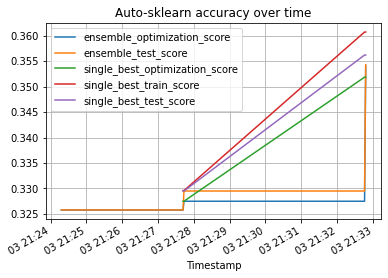

In [34]:
import matplotlib.pyplot as plt

automl.performance_over_time_.plot(
        x='Timestamp',
        kind='line',
        legend=True,
        title='Auto-sklearn accuracy over time',
        grid=True,
    )
plt.show()

In [35]:
import pprint

pp = pprint.PrettyPrinter(4)

In [36]:
pp.pprint(automl.show_models())

{   4: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7fabadcb7750>,
           'cost': 0.6725179223276556,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fabadeb0050>,
           'ensemble_weight': 0.2,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fabadcb70d0>,
           'model_id': 4,
           'rank': 2,
           'sklearn_classifier': HistGradientBoostingClassifier(early_stopping=True,
                               l2_regularization=8.169372400434849e-10,
                               learning_rate=0.08115298296694816, max_iter=128,
                               max_leaf_nodes=17, min_samples_leaf=42,
                               n_iter_no_change=16, random_state=1,
                               validation_fraction=0.1006

In [ ]:
from sklearn.inspection import plot_partial_dependence, permutation_importance

r = permutation_importance(automl, X_test, y_test, n_repeats=3, random_state=0)
sort_idx = r.importances_mean.argsort()[::-1]

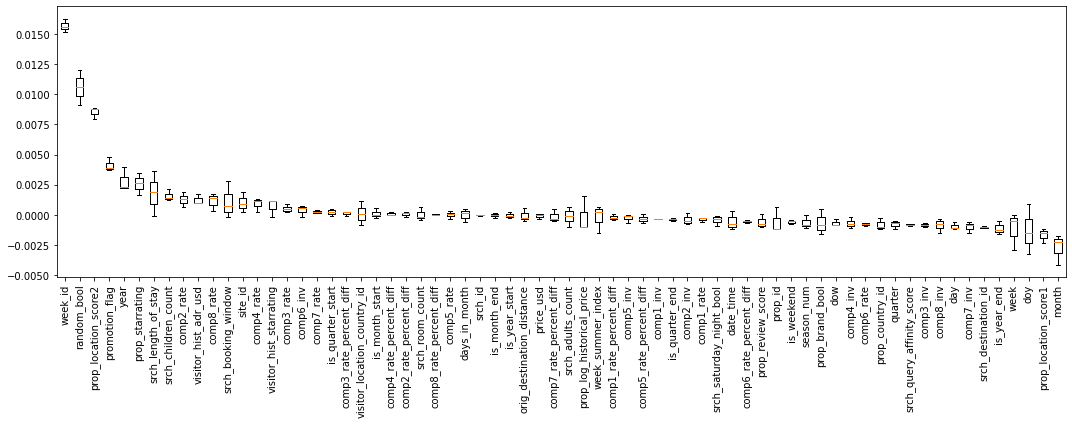

month     : -0.003 +/- 0.001
prop_location_score1: -0.002 +/- 0.000
doy       : -0.001 +/- 0.002
week      : -0.001 +/- 0.001
is_year_end: -0.001 +/- 0.000
srch_destination_id: -0.001 +/- 0.000
comp7_inv : -0.001 +/- 0.000
day       : -0.001 +/- 0.000
comp8_inv : -0.001 +/- 0.000
comp3_inv : -0.001 +/- 0.000
srch_query_affinity_score: -0.001 +/- 0.000
quarter   : -0.001 +/- 0.000
prop_country_id: -0.001 +/- 0.000
comp6_rate: -0.001 +/- 0.000
comp4_inv : -0.001 +/- 0.000
dow       : -0.001 +/- 0.000
prop_brand_bool: -0.001 +/- 0.001
season_num: -0.001 +/- 0.000
is_weekend: -0.001 +/- 0.000
prop_id   : -0.001 +/- 0.001
prop_review_score: -0.001 +/- 0.000
comp6_rate_percent_diff: -0.001 +/- 0.000
date_time : -0.001 +/- 0.001
srch_saturday_night_bool: -0.000 +/- 0.000
comp1_rate: -0.000 +/- 0.000
comp2_inv : -0.000 +/- 0.000
is_quarter_end: -0.000 +/- 0.000
comp1_inv : -0.000 +/- 0.000
comp5_rate_percent_diff: -0.000 +/- 0.000
comp5_inv : -0.000 +/- 0.000
comp1_rate_percent_diff: -0.000 +/

In [40]:
plt.figure(figsize=(15, 6))
plt.boxplot(r.importances[sort_idx].T,
            labels=[X_test.columns[i] for i in sort_idx])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(f"{X_test.columns[i]:10s}: {r.importances_mean[i]:.3f} +/- "
          f"{r.importances_std[i]:.3f}")

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from matplotlib import pyplot as plt

# fig, axes = plt.subplots(nrows=1,
#                         ncols=1,
#                         figsize=(20, 7))

# from sklearn import tree
# tree.plot_tree(list(automl.show_models().values())[0]['sklearn_classifier'], 
#                feature_names=X_test.columns, 
#             #    class_names=automl.classes_
#             filled=True,
#             max_depth=4,
#             fontsize=9,
#                );

## H2O

In [ ]:
! pip install h2o -q

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

In [ ]:
aml = H2OAutoML(max_models=25,
                stopping_metric='logloss',
                balance_classes=True,
                max_runtime_secs=minutes_limit*60,
                seed=42)

In [ ]:
#to make the automl solve clf not regr
training_frame = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
training_frame[target_col] = training_frame[target_col].asfactor()

aml.train(training_frame=training_frame, 
          x = X_train.columns.tolist(),
          y=target_col)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=10)  # Print all rows instead of default (10 rows)

In [ ]:
best_model = aml.get_best_model()
print(best_model)

In [ ]:
predictions = aml.predict(h2o.H2OFrame(X_test))
print("Accuracy score CV", sklearn.metrics.accuracy_score(y_test, 
                                                          predictions.as_data_frame()['predict']))

In [ ]:
#to make the automl solve clf not regr
testing_frame = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
testing_frame[target_col] = testing_frame[target_col].asfactor()

explain_model = aml.explain(frame = testing_frame, 
                            figsize = (8,6))

## tpot

In [ ]:
!pip install tpot

In [ ]:
from tpot import TPOTClassifier

In [ ]:
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, 
                      random_state=42,
                    #   config_dict='TPOT NN'
                      )
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

# export the minimalized code for the best model found
tpot.export('tpot_wine_pipeline.py')

In [ ]:
tpot = TPOTClassifier(generations=5, 
                      population_size=50, 
                      verbosity=2, 
                      random_state=42,
                      config_dict='TPOT NN'
                      )
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

# export the minimalized code for the best model found
tpot.export('tpot_nn_wine_pipeline.py')

In [ ]:
tpot.evaluated_individuals_

In [ ]:
tpot.pareto_front_fitted_pipelines_